In [ ]:
%pip install azure-ai-vision-imageanalysis

## Helper Functions

In [ ]:
from matplotlib import pyplot as plt
import cv2

# Function to display an image.
def show_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    # Convert the image from BGR to RGB for displaying with matplotlib,
    # because OpenCV uses BGR by default and matplotlib expects RGB.
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image with matplotlib.
    plt.imshow(img_rgb)
    plt.axis("off")  # Turn off axis labels.
    plt.show()

In [24]:
from PIL import Image, ImageDraw

# Function to display an image with bounding boxes based on the analysis result.
def show_image_with_boxes(image_path, result, type):
    # Load the image
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    if type == "objects":
        if result.objects is not None:
            for object in result.objects.list:
                # Draw bounding box
                box = object.bounding_box
                draw.rectangle([(box['x'], box['y']), (box['x'] + box['w'], box['y'] + box['h'])], outline="red", width=2)
                draw.text((box['x'], box['y'] - 10), f"{object.tags[0].name} ({object.tags[0].confidence:.2f})", fill="red")
    elif type == "people":
        if result.people is not None:
            for person in result.people.list:
                # Draw bounding box
                box = person.bounding_box
                draw.rectangle([(box['x'], box['y']), (box['x'] + box['w'], box['y'] + box['h'])], outline="red", width=2)
                draw.text((box['x'], box['y'] - 10), f"Confidence {person.confidence:.2f}", fill="red")
    elif type == "text":
        if result.read is not None:
            for line in result.read.blocks[0].lines:
                for word in line.words:
                    # Draw rectangle over the word
                    bounding_box = word.bounding_polygon
                    draw.polygon([(point['x'], point['y']) for point in bounding_box], outline="red" , width=3)

    # Save or display the image with bounding boxes
    image.show()  # To display the image
    # image.save("output_image_with_boxes.jpg")  # To save the image

## Load Azure Configuration

In [25]:
import os
azure_computer_vision_endpoint = os.environ["AZURE_COMPUTER_VISION_ENDPOINT"]
azure_computer_vision_key = os.environ["AZURE_COMPUTER_VISION_KEY"]

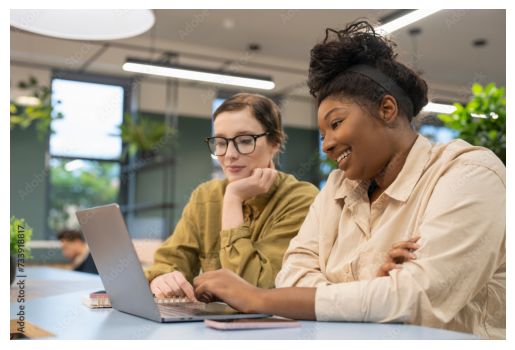

In [26]:
from azure.ai.vision.imageanalysis import ImageAnalysisClient
from azure.ai.vision.imageanalysis.models import VisualFeatures
from azure.core.credentials import AzureKeyCredential

image = "../Data/images/image_analysis.jpg"
show_image(image)

# Read the image file as bytes
with open(image, "rb") as image_file:
    image_data = image_file.read()

# Create an Image Analysis client
client = ImageAnalysisClient(
    endpoint=azure_computer_vision_endpoint,
    credential=AzureKeyCredential(azure_computer_vision_key)
)

## Caption, Dense Captions, Tags

In [27]:
# Get the feature for the image. This will be a synchronously (blocking) call.
result = client.analyze(
    image_data=image_data,
    visual_features=[VisualFeatures.CAPTION, VisualFeatures.DENSE_CAPTIONS, VisualFeatures.TAGS],
    gender_neutral_caption=True,  # Optional (default is False)
)

print("Caption:")
if result.caption is not None:
    print(f"   '{result.caption.text}', Confidence {result.caption.confidence:.4f}")

print("Dense Captions:")
for item in result.dense_captions['values']:
    print(f"   '{item['text']}', Confidence {item['confidence']:.4f}")

print("Tags:")
for item in result.tags['values']:
    print(f"   '{item['name']}', Confidence {item['confidence']:.4f}")

Caption:
   'a group of women looking at a laptop', Confidence 0.8003
Dense Captions:
   'a group of women looking at a laptop', Confidence 0.8001
   'a person using a laptop', Confidence 0.6837
   'a group of women sitting at a table looking at a laptop', Confidence 0.7783
   'a person in glasses looking at a laptop', Confidence 0.7199
   'a close up of a person's face wearing glasses', Confidence 0.8067
   'blur a blurry picture of a window', Confidence 0.7301
   'a person smiling at something', Confidence 0.6836
   'a close up of a white plate', Confidence 0.7880
   'blur a blurry image of a window', Confidence 0.7391
   'a blurry image of a plant', Confidence 0.7733
Tags:
   'person', Confidence 0.9959
   'clothing', Confidence 0.9925
   'human face', Confidence 0.9852
   'indoor', Confidence 0.9411
   'laptop', Confidence 0.9277
   'computer', Confidence 0.8835
   'sitting', Confidence 0.8741
   'office building', Confidence 0.8416
   'table', Confidence 0.8114
   'window', Confid

## Objects

 Objects:
   'Whiteboard', {'x': 8, 'y': 12, 'w': 513, 'h': 511}, Confidence: 0.5650
 Image height: 585
 Image width: 580


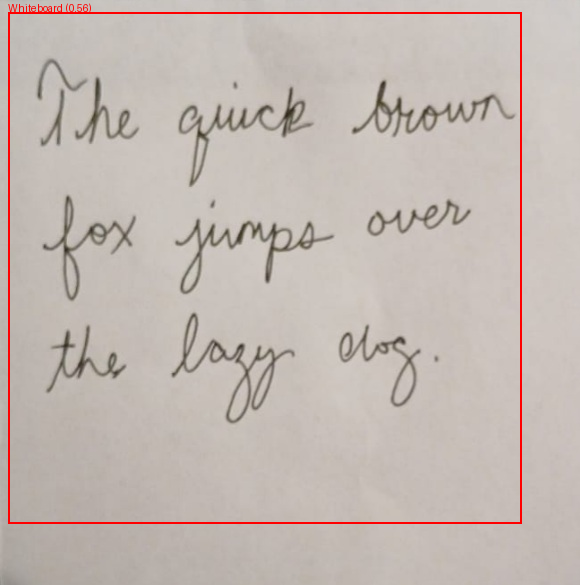

In [34]:
# Get the feature for the image. This will be a synchronously (blocking) call.
result = client.analyze(
    image_data=image_data,
    visual_features=[VisualFeatures.OBJECTS],
    gender_neutral_caption=True,  # Optional (default is False)
)

 # Print Objects analysis results to the console
print(" Objects:")
if result.objects is not None:
    for object in result.objects.list:
        print(f"   '{object.tags[0].name}', {object.bounding_box}, Confidence: {object.tags[0].confidence:.4f}")
print(f" Image height: {result.metadata.height}")
print(f" Image width: {result.metadata.width}")

show_image_with_boxes(image, result, "objects")

## Smart Crops

Thumbnails often need to have a certain aspect ratio, where aspect ratio is defined as the width in pixels divided by the height in pixels. For example, 1.0 for a square image, or 1.77 for a 16:9 widescreen image.

You can optionally request one or more aspect ratios by setting the `smart_crops_aspect_ratios` argument in the call to `analyze`. Supported values are from 0.75 to 1.8 (inclusive).

If you do not set this value, the service will return one result with an aspect ratio it sees fit between 0.5 and 2.0 (inclusive).

In [30]:
# Do Smart Cropping analysis on an image stream. This will be a synchronously (blocking) call.
result = client.analyze(
    image_data=image_data,
    visual_features=[VisualFeatures.SMART_CROPS],
    smart_crops_aspect_ratios=[1.0],  # Optional. Specify one more desired aspect ratios    
)

if result.smart_crops is not None:
    for smart_crop in result.smart_crops.list:
        print(f"Aspect ratio {smart_crop.aspect_ratio}: Smart crop {smart_crop.bounding_box}")
print(f" Image height: {result.metadata.height}")
print(f" Image width: {result.metadata.width}")


Aspect ratio 1.0: Smart crop {'x': 83, 'y': 0, 'w': 662, 'h': 661}
 Image height: 667
 Image width: 1000


## Show Cropped Image

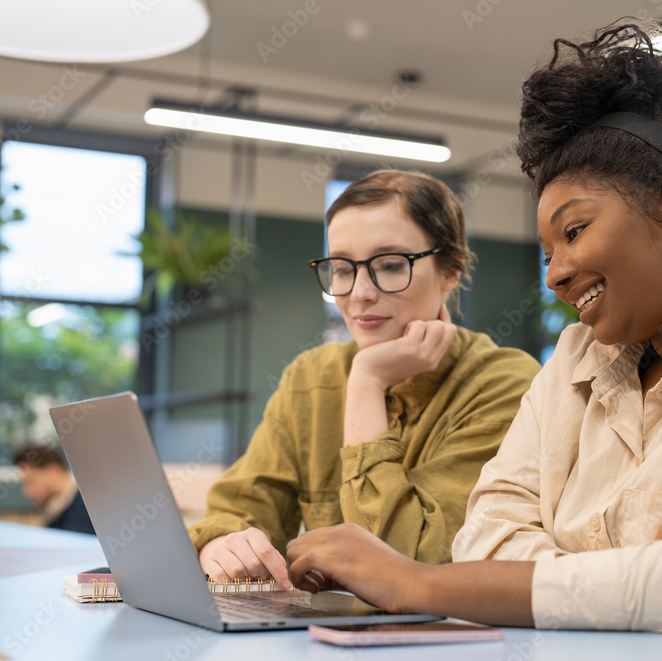

In [31]:
from PIL import Image

# Load the original image
original_image = Image.open(image)

# Define the bounding box (x, y, w, h)
bounding_box = {'x': 83, 'y': 0, 'w': 662, 'h': 661}

# Crop the image using the bounding box
cropped_image = original_image.crop((bounding_box['x'], bounding_box['y'], 
                                     bounding_box['x'] + bounding_box['w'], 
                                     bounding_box['y'] + bounding_box['h']))

# Display the cropped image
cropped_image.show()

## People

 People:
   {'x': 269, 'y': 165, 'w': 358, 'h': 428}, Confidence 0.9321
   {'x': 364, 'y': 10, 'w': 635, 'h': 654}, Confidence 0.9289
   {'x': 93, 'y': 443, 'w': 90, 'h': 93}, Confidence 0.0548
   {'x': 554, 'y': 207, 'w': 316, 'h': 264}, Confidence 0.0026
 Image height: 667
 Image width: 1000


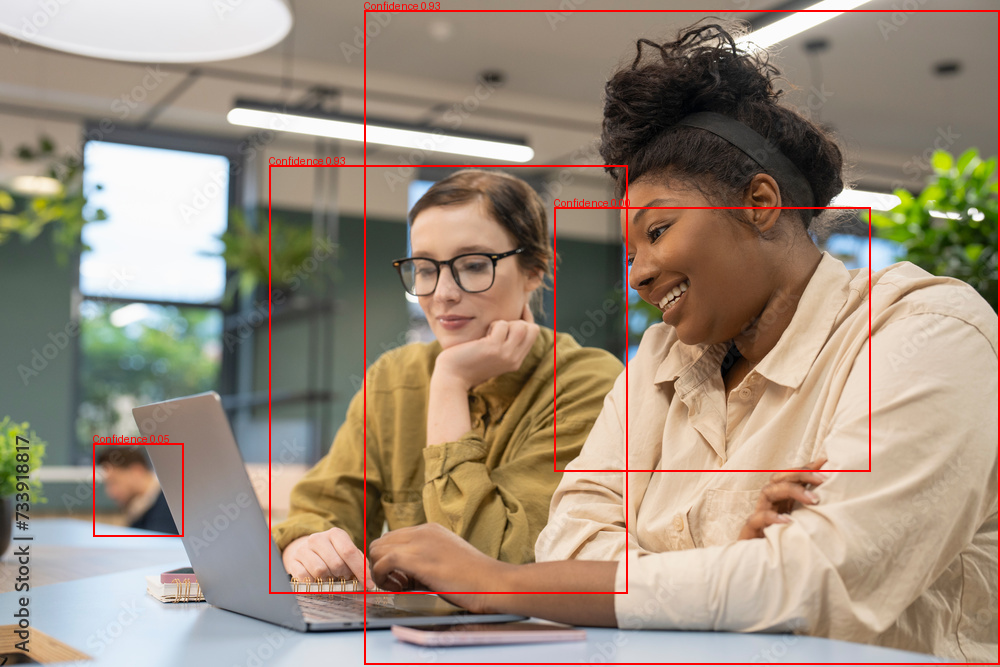

In [32]:
# Find people in an image stream. This will be a synchronously (blocking) call.
result = client.analyze(
    image_data=image_data,
    visual_features=[VisualFeatures.PEOPLE]
)

# Print People analysis results to the console
print(" People:")
if result.people is not None:
    for person in result.people.list:
        print(f"   {person.bounding_box}, Confidence {person.confidence:.4f}")
print(f" Image height: {result.metadata.height}")
print(f" Image width: {result.metadata.width}")

show_image_with_boxes(image, result, "people")

## Text

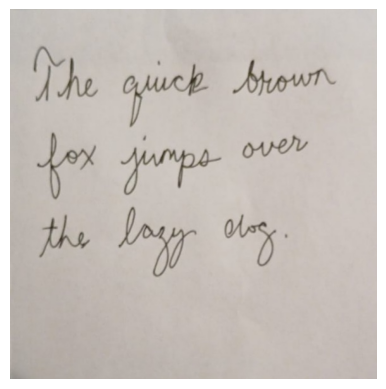

 Read:
   Line: 'The quick brown', Bounding box [{'x': 51, 'y': 92}, {'x': 513, 'y': 79}, {'x': 515, 'y': 131}, {'x': 51, 'y': 147}]
     Word: 'The', Bounding polygon [{'x': 53, 'y': 92}, {'x': 141, 'y': 90}, {'x': 141, 'y': 145}, {'x': 52, 'y': 147}], Confidence 0.7840
     Word: 'quick', Bounding polygon [{'x': 175, 'y': 89}, {'x': 311, 'y': 85}, {'x': 312, 'y': 140}, {'x': 175, 'y': 145}], Confidence 0.8420
     Word: 'brown', Bounding polygon [{'x': 365, 'y': 83}, {'x': 508, 'y': 79}, {'x': 512, 'y': 128}, {'x': 368, 'y': 137}], Confidence 0.8930
   Line: 'fox jumps over', Bounding box [{'x': 48, 'y': 204}, {'x': 471, 'y': 187}, {'x': 475, 'y': 243}, {'x': 48, 'y': 264}]
     Word: 'fox', Bounding polygon [{'x': 50, 'y': 204}, {'x': 137, 'y': 205}, {'x': 138, 'y': 262}, {'x': 50, 'y': 264}], Confidence 0.9240
     Word: 'jumps', Bounding polygon [{'x': 178, 'y': 204}, {'x': 321, 'y': 199}, {'x': 324, 'y': 251}, {'x': 179, 'y': 261}], Confidence 0.9530
     Word: 'over', Bounding p

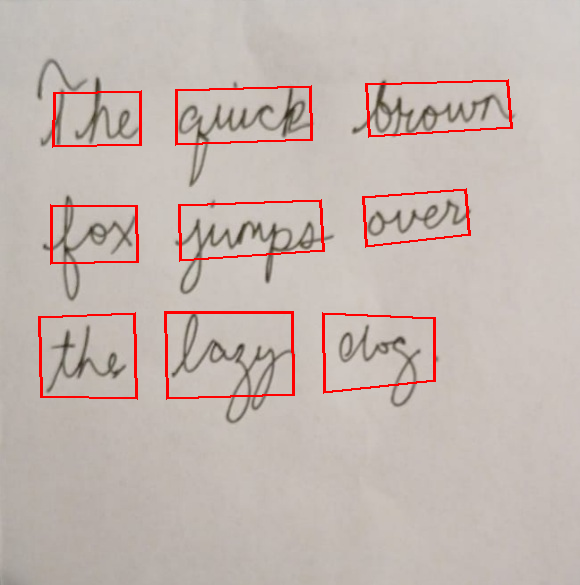

In [33]:
image = "../Data/images/ocr.jpg"
show_image(image)

# Read the image file as bytes
with open(image, "rb") as image_file:
    image_data = image_file.read()


# Extract text (OCR) from an image stream. This will be a synchronously (blocking) call.
result = client.analyze(
    image_data=image_data,
    visual_features=[VisualFeatures.READ]
)

# Print text (OCR) analysis results to the console
print(" Read:")
if result.read is not None:
    for line in result.read.blocks[0].lines:
        print(f"   Line: '{line.text}', Bounding box {line.bounding_polygon}")
        for word in line.words:
            print(f"     Word: '{word.text}', Bounding polygon {word.bounding_polygon}, Confidence {word.confidence:.4f}")

print(f" Image height: {result.metadata.height}")
print(f" Image width: {result.metadata.width}")

show_image_with_boxes(image, result, "text")